### **Install Ludwig and Ludwig's LLM related dependencies.**

In [ ]:
!pip uninstall -y tensorflow --quiet

In [ ]:
!pip install ludwig --quiet
!pip install ludwig[llm] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 12.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 22.3 MB/s eta 0:00

In [ ]:
!pip show torch

Name: torch
Version: 2.1.0+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, triton, typing-extensions
Required-by: accelerate, fastai, ludwig, peft, sentence-transformers, torchaudio, torchdata, torchmetrics, torchtext, torchvision


In [ ]:
!pip show transformers

Name: transformers
Version: 4.35.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: ludwig, peft, sentence-transformers


In [ ]:
!pip show peft

Name: peft
Version: 0.7.0
Summary: Parameter-Efficient Fine-Tuning (PEFT)
Home-page: https://github.com/huggingface/peft
Author: The HuggingFace team
Author-email: sourab@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: accelerate, huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch, tqdm, transformers
Required-by: 


In [ ]:

import os

import copy

import gc

from typing import Any, Callable, cast

import time

from functools import wraps
from inspect import (
    BoundArguments,
    signature,
)

from collections import OrderedDict

from google.colab import data_table, drive

import json
import yaml

import numpy as np
import pandas as pd

import torch
from torch import Tensor

import transformers
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, LlamaForCausalLM, MistralForCausalLM, AutoTokenizer, LlamaTokenizerFast, GenerationConfig, TextGenerationPipeline, BatchEncoding
from transformers.generation.utils import GreedySearchDecoderOnlyOutput

from peft import PeftModel, PeftModelForCausalLM, PeftConfig, LoraConfig

from ludwig.api import LudwigModel, TrainingResults


import logging

Enable text wrapping so we don't have to scroll horizontally and create a function to flush CUDA cache.

In [ ]:
from IPython.display import HTML, display

def set_css() -> None:
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)


In [ ]:
def predict(model: LudwigModel, df_test: pd.DataFrame) -> list[list[str]]:
  return model.predict(dataset=df_test)[0]["task_type_response"].tolist()

### **Setup Your HuggingFace Token** 🤗

Obtain a [HuggingFace API Token](https://huggingface.co/settings/tokens) before proceeding. You may need to signup on HuggingFace if you do not aleady have an account: https://huggingface.co/join


In [ ]:
import getpass
# import locale; locale.getpreferredencoding = lambda: "UTF-8"

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


### **Import the Gridspace-Stanford-HarperValley Dataset**



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !ls /content/drive/MyDrive/GridSpaceStanfordHarperValley/gridspace-stanford-harper-valley/data/transcript

In [ ]:
transcript_files_path: str = "/content/drive/MyDrive/GridSpaceStanfordHarperValley/gridspace-stanford-harper-valley/data/transcript"
metadata_files_path: str = "/content/drive/MyDrive/GridSpaceStanfordHarperValley/gridspace-stanford-harper-valley/data/metadata"

In [ ]:
# os.listdir(transcript_files_path)

In [ ]:
file_names: list[str] = os.listdir(transcript_files_path)

In [ ]:
len(file_names)

1446

In [ ]:
gc.collect()

1142

In [ ]:
file_name: str

In [ ]:
all_transcripts: list[str] = []

transcript_file_name: str
transcript_file_path: str

conversation_turns: list[dict]
turn_item: dict

transcript_part_list: list[str]
transcript_part: str
transcript_text: str

for file_name in file_names:
    transcript_file_path = os.path.join(transcript_files_path, file_name)
    with open(transcript_file_path, 'r') as transcript_file:
        conversation_turns = json.load(transcript_file)

        transcript_part_list = []
        for turn_item in conversation_turns:
          transcript_part = f'<{turn_item["speaker_role"]}>' + " " + turn_item["human_transcript"]
          transcript_part_list.append(transcript_part)

        transcript_text = " ".join(transcript_part for transcript_part in transcript_part_list)
        all_transcripts.append(transcript_text)


In [ ]:
len(all_transcripts)

1446

In [ ]:
all_task_types: list[str] = []

metadata_file_name: str
metadata_file_path: str

task_type: str

for file_name in file_names:
    metadata_file_path = os.path.join(metadata_files_path, file_name)
    with open(metadata_file_path, 'r') as metadata_file:
        metadata = json.load(metadata_file)

        task_type = metadata["tasks"][0]["task_type"]
        all_task_types.append(task_type)


In [ ]:
len(all_task_types)

1446

In [ ]:
raw_data: dict = {"transcript": all_transcripts, "task_type": all_task_types}

In [ ]:
df_dataset_original: pd.DataFrame = pd.DataFrame(data=raw_data)

In [ ]:
df_dataset_original.shape

(1446, 2)

In [ ]:
df_dataset_original.head(n=10)

,transcript,task_type
0,<agent> hello this is harper valley national b...,replace card
1,<agent> hello this is harper valley national b...,schedule appointment
2,<agent> [noise] hello this is harper valley na...,reset password
3,<agent> hello this is harper valley nation my ...,get branch hours
4,<agent> hello this is harper valley national b...,transfer money
5,<agent> hello this is harper valley national b...,reset password
6,<agent> <unk> this is harper valley national b...,order checks
7,<agent> hello this is harper valley national b...,check balance
8,<agent> hello this is harper valley national b...,schedule appointment
9,<agent> hello this is harper valley national b...,pay bill


In [ ]:
df_dataset_original.tail(n=10)

,transcript,task_type
1436,<agent> hello this is harper valley national b...,check balance
1437,<agent> hello this is harper value national ba...,pay bill
1438,<caller> [noise] <agent> [noise] hello this is...,reset password
1439,<agent> hello this is harper valley national b...,transfer money
1440,<agent> [noise] hello this is harper valley na...,transfer money
1441,<agent> [noise] hello this is harper valley na...,order checks
1442,<agent> hello this is harper valley national b...,check balance
1443,<agent> hello this is harper <agent> [noise] <...,get branch hours
1444,<agent> hello this is harper valley national b...,get branch hours
1445,<agent> hello thank you for calling harper val...,pay bill


In [ ]:
df_train: pd.DataFrame = df_dataset_original.copy()


In [ ]:
df_evaluation: pd.DataFrame = df_train.sample(n=10, random_state=200)
df_train = df_train.drop(df_evaluation.index)

In [ ]:
df_test = df_train.sample(n=200, random_state=200)
df_train = df_train.drop(df_test.index)

In [ ]:
df_validation = df_train.sample(n=100, random_state=200)
df_train = df_train.drop(df_validation.index)

In [ ]:
df_train = df_train.sample(n=700, random_state=200)

In [ ]:
assert df_train.shape[0] == 700
assert df_test.shape[0] == 200
assert df_validation.shape[0] == 100

In [ ]:
data_table.enable_dataframe_formatter()
np.random.seed(123)

In [ ]:
df_train["split"] = np.zeros(df_train.shape[0])
df_test["split"] = np.ones(df_test.shape[0])
df_validation["split"] = np.full(df_validation.shape[0], 2)

In [ ]:
df_dataset = pd.concat([df_train, df_test, df_validation])

In [ ]:
df_dataset["split"] = df_dataset["split"].astype(int)

In [ ]:
df_dataset.shape

(1000, 3)

In [ ]:
assert df_dataset[df_dataset["split"] == 0].shape[0] == 700
assert df_dataset[df_dataset["split"] == 1].shape[0] == 200
assert df_dataset[df_dataset["split"] == 2].shape[0] == 100

In [ ]:
df_dataset.head(n=10)

,transcript,task_type,split
48,<agent> hello this is harper valley national b...,check balance,0
983,<agent> harper valley national bank <caller> [...,schedule appointment,0
570,<agent> hello this is harper valley national b...,reset password,0
230,<caller> [noise] <agent> [noise] hello this is...,pay bill,0
824,<agent> hello this is harper valley national b...,get branch hours,0
481,<caller> [noise] <caller> [noise] <agent> hell...,check balance,0
140,<caller> [noise] <agent> hello this is harper ...,replace card,0
1245,<agent> hello this is harper valley national b...,check balance,0
258,<caller> [noise] <agent> hello this is harper ...,get branch hours,0
1353,<caller> [noise] <agent> hello this is harper ...,transfer money,0


Average number of tokens in the transcript column: 224
Average number of tokens in the task_type column: 5


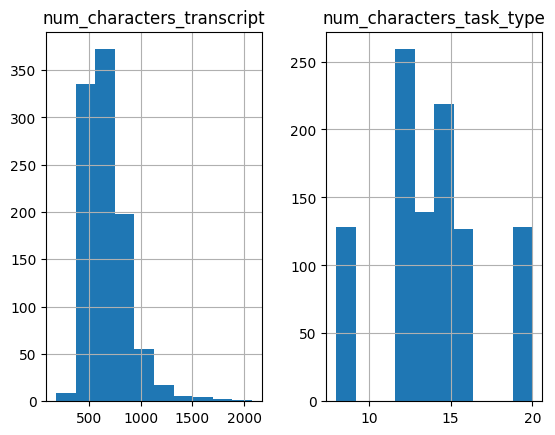

In [ ]:
# Calculating the length of each cell in each column
df_dataset['num_characters_transcript'] = df_dataset['transcript'].apply(lambda x: len(x))
df_dataset['num_characters_task_type'] = df_dataset['task_type'].apply(lambda x: len(x))

# Show Distribution
df_dataset.hist(column=['num_characters_transcript', 'num_characters_task_type'])

# Calculating the average
average_chars_transcript = df_dataset['num_characters_transcript'].mean()
average_chars_task_type = df_dataset['num_characters_task_type'].mean()

print(f'Average number of tokens in the transcript column: {(average_chars_transcript / 3):.0f}')
print(f'Average number of tokens in the task_type column: {(average_chars_task_type / 3):.0f}')


In [ ]:
df_evaluation

,transcript,task_type
1254,<agent> hello this is harper valley national b...,pay bill
538,<agent> hello this is harper valley national b...,get branch hours
1016,<agent> [noise] hello this is harper valley na...,transfer money
987,<caller> [noise] hello my name is elizabeth wi...,reset password
718,<agent> [noise] hello this is harper valley na...,reset password
866,<agent> hello this is harper valley national b...,get branch hours
863,<agent> [noise] <agent> [noise] hello this is ...,get branch hours
946,<agent> hello this is harper valley national b...,reset password
398,<agent> [noise] hello this is harper valley na...,check balance
1127,<agent> hello this is harper valley national b...,schedule appointment


In [ ]:
prompt_template: str = """
Consider the case of a customer contacting the support center.
The term "task type" refers to the reason for why the customer contacted support.

### The possible task types are: ###
- replace card
- transfer money
- check balance
- order checks
- pay bill
- reset password
- schedule appointment
- get branch hours
- none of the above

Summarize the issue/question/reason that drove the customer to contact support:

### Transcript: {transcript}

### Task Type:
"""

In [ ]:
test_transcript: str = """
<caller> hello <agent> hello this is [unintelligible] national bank my name is jennifer <agent> how can i help you today <caller> hi my name is james william <caller> i lost my debit card <caller> can you send me a new one <agent> yes <agent> uh which card or would you like to replace <caller> my debit card <agent> okay i've ordered your replacement debit card is there anything else i can help you with today <caller> no that's gonna be all for me today <agent> [noise] <agent> alright thank you for calling have a great day <caller> you too bye <agent> [noise] <agent> [noise]
"""

In [ ]:
test_prompt: str = prompt_template.format(**{"transcript": test_transcript})

In [ ]:
zephyr_base_model_name: str = "HuggingFaceH4/zephyr-7b-beta"

In [ ]:
bnb_config_base_model: BitsAndBytesConfig = BitsAndBytesConfig(
    load_in_4bit=True,
    load_in_8bit=False,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

In [ ]:
base_model_tokenizer: LlamaTokenizerFast = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=zephyr_base_model_name, trust_remote_code=True, padding_side="left")
print(base_model_tokenizer.eos_token)
base_model_tokenizer.pad_token = base_model_tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

</s>


In [ ]:
base_model: MistralForCausalLM = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=zephyr_base_model_name, device_map="auto", torch_dtype=torch.float16, offload_folder="offload", trust_remote_code=True, low_cpu_mem_usage=True, quantization_config=bnb_config_base_model)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Run inference on the pre-trained (general) Mistral 7B LLM to establish baseline quality.

In [ ]:
base_model_sequences_generator: TextGenerationPipeline = transformers.pipeline(
    task="text-generation",
    tokenizer=base_model_tokenizer,
    model=base_model,
    torch_dtype=torch.float16,
    device_map="auto",
)

In [ ]:
base_model_sequences: list[dict] | list[list[dict]] = base_model_sequences_generator(
    text_inputs=test_prompt,
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=base_model_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

In [ ]:
base_model_sequence: dict = base_model_sequences[0]

In [ ]:
print(f'\n[GENERATED_TEXT] BASE_MODEL_PREDICTION:\n{base_model_sequence["generated_text"]} ; TYPE: {str(type(base_model_sequence["generated_text"]))}')


[GENERATED_TEXT] BASE_MODEL_PREDICTION:

Consider the case of a customer contacting the support center.
The term "task type" refers to the reason for why the customer contacted support.

### The possible task types are: ###  
- replace card
- transfer money
- check balance
- order checks
- pay bill
- reset password
- schedule appointment
- get branch hours
- none of the above

Summarize the issue/question/reason that drove the customer to contact support:

### Transcript: 
<caller> hello <agent> hello this is [unintelligible] national bank my name is jennifer <agent> how can i help you today <caller> hi my name is james william <caller> i lost my debit card <caller> can you send me a new one <agent> yes <agent> uh which card or would you like to replace <caller> my debit card <agent> okay i've ordered your replacement debit card is there anything else i can help you with today <caller> no that's gonna be all for me today <agent> [noise] <agent> alright thank you for calling have a gre

In [ ]:
gc.collect()

0

Run inference on the pre-trained (general) Mistral 7B LLM over the evaluation dataset.

In [ ]:
df_harper_valley_evaluation: pd.DataFrame = df_evaluation.copy()

In [ ]:
df_harper_valley_evaluation["prompt"] = df_harper_valley_evaluation["transcript"].apply(lambda x: prompt_template.format(**{"transcript": x}))

In [ ]:
base_model_sequences = base_model_sequences_generator(
    text_inputs=df_harper_valley_evaluation["prompt"].to_list(),
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=base_model_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

In [ ]:
# print(base_model_sequences)

In [ ]:
print(f'\n[BASE_MODEL_EVALUATION_BEGIN]')
idx: int = 0
print(f'\n[=============EXAMPLE_{idx}_BEGIN=============]')
for transcript, task_type in zip(df_harper_valley_evaluation["transcript"].to_list(), base_model_sequences):
  print(f'\n[BASE_MODEL_EVALUATION] GENERATED_TASK_TYPE:\n{task_type[0]["generated_text"]}')
  print(f'\n[=============EXAMPLE_{idx}_END=============]')
  idx += 1

print(f'\n[BASE_MODEL_EVALUATION_END]')


[BASE_MODEL_EVALUATION_BEGIN]

[=============EXAMPLE_0_BEGIN=============]

[BASE_MODEL_EVALUATION] GENERATED_TASK_TYPE:

Consider the case of a customer contacting the support center.
The term "task type" refers to the reason for why the customer contacted support.

### The possible task types are: ###  
- replace card
- transfer money
- check balance
- order checks
- pay bill
- reset password
- schedule appointment
- get branch hours
- none of the above

Summarize the issue/question/reason that drove the customer to contact support:

### Transcript: <agent> hello this is harper valley national bank my name is james how can i help you today <caller> [noise] <caller> hi my name is michael garcia i would like to pay a bill <agent> [noise] <agent> what's the company name <caller> fossil gas <agent> [noise] <agent> [noise] <agent> [noise] <agent> and what is the company address <caller> the address is one ninety main street <caller> forest ranch <caller> oregon <agent> [noise] <caller> s

In [ ]:
gc.collect()

0

Configure and execute finetuning process.

In [ ]:
qlora_fine_tuning_config: dict = yaml.safe_load(
"""
model_type: llm
base_model: HuggingFaceH4/zephyr-7b-beta

input_features:
  - name: transcript
    type: text
    preprocessing:
      max_sequence_length: 1024

output_features:
  - name: task_type
    type: text
    preprocessing:
      max_sequence_length: 384

prompt:
  template: >-
    Consider the case of a customer contacting the support center.
    The term "task type" refers to the reason for why the customer contacted support.

    ### The possible task types are: ###
    - replace card
    - transfer money
    - check balance
    - order checks
    - pay bill
    - reset password
    - schedule appointment
    - get branch hours
    - none of the above

    Summarize the issue/question/reason that drove the customer to contact support:

    ### Transcript: {transcript}

    ### Task Type:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  split:
    # type: random
    # probabilities: [0.9, 0.05, 0.05]
    type: fixed

trainer:
  type: finetune
  epochs: 5
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16  # effective batch size = batch size * gradient_accumulation_steps
  learning_rate: 2.0e-4
  enable_gradient_checkpointing: true
  learning_rate_scheduler:
    decay: cosine
    warmup_fraction: 0.03
    reduce_on_plateau: 0
"""
)

In [ ]:
model: LudwigModel = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)

In [ ]:
results: TrainingResults = model.train(dataset=df_dataset)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of HuggingFaceH4/zephyr-7b-beta tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.trainers.trainer:Gradient checkpointing enabled for training.
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.04703666202518836


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 3500 step(s), approximately 5 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 3500 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:   0%|          | 0/3500 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Training:  20%|██        | 700/3500 [16:53<1:03:52,  1.37s/it, loss=1.73e-5]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 700, epoch: 0


Evaluation test : 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]

INFO:ludwig.trainers.trainer:Evaluation took 2m 13.1147s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │    78.5040 │      85.9090 │    87.9338 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     2.0574 │       0.0674 │     0.0916 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 15014.2695 │   12100.1748 │ 12230.1523 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31973.4023 │   31957.1230 │ 31957.7656 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Training:  40%|████      | 1400/3500 [35:46<50:20,  1.44s/it, loss=1.52e-5]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1400, epoch: 1


Evaluation test : 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]

INFO:ludwig.trainers.trainer:Evaluation took 2m 12.7103s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │    82.8108 │      83.8800 │    86.1392 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.0007 │       0.0773 │     0.0897 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 11780.9473 │   12201.2070 │ 12260.6875 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31991.6738 │   31918.0156 │ 31892.6992 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Training:  60%|██████    | 2100/3500 [54:38<35:01,  1.50s/it, loss=6e-6]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2100, epoch: 2


Evaluation test : 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]

INFO:ludwig.trainers.trainer:Evaluation took 2m 12.6134s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │    70.8771 │      85.1113 │    86.9142 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.0003 │       0.0379 │     0.0628 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 11776.5850 │   12016.7754 │ 12132.3623 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31983.0098 │   31940.0625 │ 31922.9766 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Training:  80%|████████  | 2800/3500 [1:13:28<16:45,  1.44s/it, loss=1.46e-5]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2800, epoch: 3


Evaluation test : 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]

INFO:ludwig.trainers.trainer:Evaluation took 2m 12.3010s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │    83.0305 │      84.5641 │    86.4191 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.0002 │       0.0400 │     0.0779 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 11775.1445 │   12004.2539 │ 12166.4121 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31970.2031 │   31923.1602 │ 31896.9297 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Training: 100%|██████████| 3500/3500 [1:32:17<00:00,  1.35s/it, loss=9.96e-6]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 3500, epoch: 4


Evaluation test : 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]

INFO:ludwig.trainers.trainer:Evaluation took 2m 12.4247s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │    73.0442 │      82.7405 │    84.5350 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.0002 │       0.0580 │     0.0959 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 11774.8164 │   12101.4697 │ 12232.5479 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31950.2988 │   31768.3027 │ 31747.7363 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0


Training: 100%|██████████| 3500/3500 [1:34:30<00:00,  1.62s/it, loss=9.96e-6]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤══════════════════════╕
│ Validation feature           │ task_type            │
├──────────────────────────────┼──────────────────────┤
│ Validation metric            │ loss                 │
├──────────────────────────────┼──────────────────────┤
│ Best model step              │ 2100                 │
├──────────────────────────────┼──────────────────────┤
│ Best model epoch             │ 3                    │
├──────────────────────────────┼──────────────────────┤
│ Best model's validation loss │ 0.037884775549173355 │
├──────────────────────────────┼──────────────────────┤
│ Best model's test loss       │ 0.06276746839284897  │
╘══════════════════════════════╧══════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_ru

#### Perform Inference

We can now use the model we finetuned above to make predictions on some test examples to see whether finetuning the large language model improve its ability to follow instructions/the tasks we're asking it to perform.

In [ ]:
predictions_and_probabilities: tuple[pd.DataFrame, pd.DataFrame] = model.predict(df_evaluation)

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of HuggingFaceH4/zephyr-7b-beta tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/ludwig/data/preprocessing.py:1308: UserWarning: column: 'split' is required by the dataset splitter with params: {'type': 'fixed', 'column': 'split'}, but 'split' is not present in the `dataset_df` with columns: Index(['transcript', 'task_type'], dtype='object'). This is acceptable during serving setting where dataset splitting is irrelevant. You may see this warning if, for example, the model was trained with a configuration that used a stratified split on the target column, but for live predictions, a value for the target column is not to be provided.
  warnings.warn(


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: consider the case of a customer contacting the support center. the term "task type" refers to the reason for why the customer contacted support.
### the possible task types are: ###   - replace card - transfer money - check balance - order checks - pay bill - reset password - schedule appointment - get branch hours - none of the above
summarize the issue/question/reason that drove the customer to contact support:
### transcript: <agent> hello this is harper valley national bank my name is james how can i help you today <caller> [noise] <caller> hi my name is michael garcia i would like to pay a bill <agent> [noise] <agent> what's the company name <caller> fossil gas <agent> [noise] <agent> [noise] <agent> [noise] <agent> and what is the company address <caller> the address is one ninety main street <caller> forest ranch <caller> oregon <agent> [noise] <caller> seven five seven four two <agent> and what's the bil

Prediction: 100%|██████████| 1/1 [00:09<00:00,  9.68s/it]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of HuggingFaceH4/zephyr-7b-beta tokenizer
/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [ ]:
df_predictions: pd.DataFrame = predictions_and_probabilities[0]

In [ ]:
df_predictions.columns

Index(['task_type_predictions', 'task_type_probabilities',
       'task_type_response', 'task_type_probability'],
      dtype='object')

In [ ]:
print("\n\n")
for transcript_with_task_type in zip(df_evaluation['transcript'], df_predictions['task_type_response']):
  print(f"Transcript:\n{transcript_with_task_type[0]}")
  print(f"Generated Task_Type:\n{transcript_with_task_type[1][0]}")
  print("\n\n")




Transcript:
<agent> hello this is harper valley national bank my name is james how can i help you today <caller> [noise] <caller> hi my name is michael garcia i would like to pay a bill <agent> [noise] <agent> what's the company name <caller> fossil gas <agent> [noise] <agent> [noise] <agent> [noise] <agent> and what is the company address <caller> the address is one ninety main street <caller> forest ranch <caller> oregon <agent> [noise] <caller> seven five seven four two <agent> and what's the bill amount <caller> the amount of the bill is fifty dollars <agent> uhm we will send your payment to fossil gas fo fifty dollars is there anything else i can help you with today <caller> no <agent> okay thank you for calling have a great day
Generated Task_Type:
pay bill



Transcript:
<agent> hello this is harper valley national bank my name is michael how can i help you today <caller> hi my name is robert jones <caller> what are the local branch hours <agent> hi robert um the branch hours

In [ ]:
df_control_example: pd.DataFrame = pd.DataFrame(
    data={
      "transcript": [test_transcript,],
    }
)
df_control_example

,transcript
0,\n<caller> hello <agent> hello this is [uninte...


In [ ]:
predictions: list[list[str]] = predict(model=model, df_test=df_control_example)

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of HuggingFaceH4/zephyr-7b-beta tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/ludwig/data/preprocessing.py:1308: UserWarning: column: 'split' is required by the dataset splitter with params: {'type': 'fixed', 'column': 'split'}, but 'split' is not present in the `dataset_df` with columns: Index(['transcript'], dtype='object'). This is acceptable during serving setting where dataset splitting is irrelevant. You may see this warning if, for example, the model was trained with a configuration that used a stratified split on the target column, but for live predictions, a value for the target column is not to be provided.
  warnings.warn(


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: consider the case of a customer contacting the support center. the term "task type" refers to the reason for why the customer contacted support.
### the possible task types are: ###   - replace card - transfer money - check balance - order checks - pay bill - reset password - schedule appointment - get branch hours - none of the above
summarize the issue/question/reason that drove the customer to contact support:
### transcript: 
<caller> hello <agent> hello this is [unintelligible] national bank my name is jennifer <agent> how can i help you today <caller> hi my name is james william <caller> i lost my debit card <caller> can you send me a new one <agent> yes <agent> uh which card or would you like to replace <caller> my debit card <agent> okay i've ordered your replacement debit card is there anything else i can help you with today <caller> no that's gonna be all for me today <agent> [noise] <agent> alright th

Prediction: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of HuggingFaceH4/zephyr-7b-beta tokenizer
/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [ ]:
one_prediction: str = predictions[0][0]
print(f'\n[GENERATED_TEXT] PREDICTION:\n{one_prediction}')


[GENERATED_TEXT] PREDICTION:
replace card


# **Upload Trained Model Artifacts To HuggingFace** 🤗

Now that we have a fine-tuned model, we can export the model weights to HuggingFace hub so we can use them in downstream tasks or in production. Ludwig supports uploading model weights directly to HuggingFace Hub via the `upload` Ludwig command.

```
!ludwig upload hf_hub --repo_id <hf_user_name>/<repo_name> --model_path <top_level_model_directory>
```

The `model-path` can be seen at the end of training/fine-tuning, as seen in this screenshot.

<br>

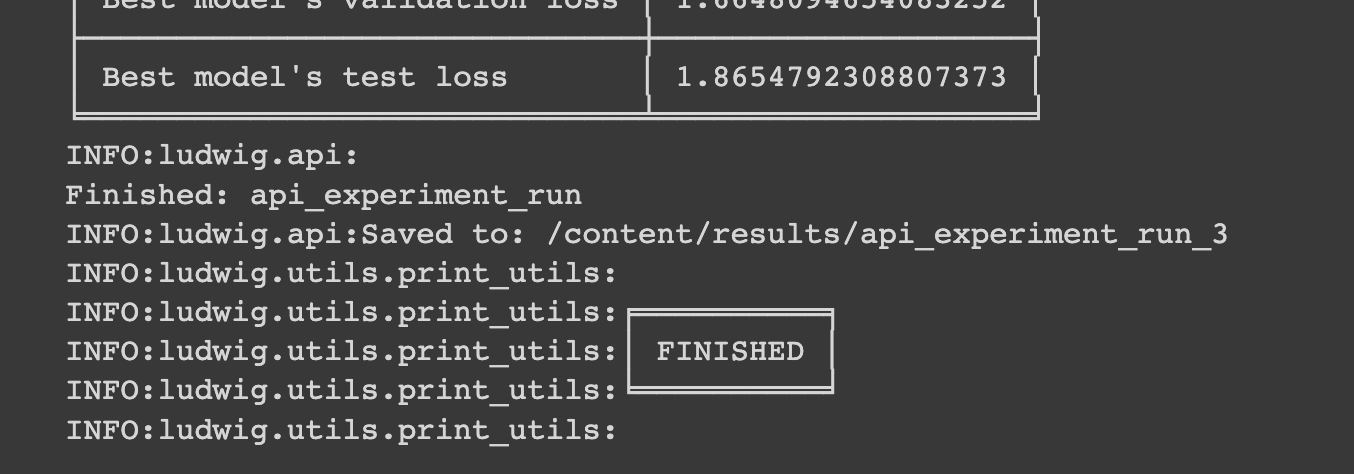

In [ ]:
!ludwig upload hf_hub --repo_id "alexsherstinsky/zephyr-7B-beta-based-finetuned-using-ludwig-with-harper_valley-T4-sharded-4bit-notmerged" --model_path /content/results/api_experiment_run

adapter_model.safetensors:   0% 0.00/13.6M [00:00<?, ?B/s]
Upload 2 LFS files:   0% 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0% 0.00/13.6M [00:00<?, ?B/s]

adapter_model.safetensors:   0% 16.4k/13.6M [00:00<02:21, 96.3kB/s]

adapter_model.safetensors:  77% 10.5M/13.6M [00:00<00:00, 30.2MB/s]

adapter_model.safetensors: 100% 13.6M/13.6M [00:01<00:00, 12.0MB/s]


adapter_model.safetensors:  22% 2.95M/13.6M [00:01<00:05, 1.92MB/s]

adapter_model.safetensors:  36% 4.93M/13.6M [00:01<00:02, 4.13MB/s]

adapter_model.safetensors:  44% 5.96M/13.6M [00:01<00:01, 4.92MB/s]
Upload 2 LFS files:  50% 1/2 [00:01<00:01,  1.54s/it]

adapter_model.safetensors:  59% 8.11M/13.6M [00:01<00:00, 7.16MB/s]

adapter_model.safetensors:  73% 9.98M/13.6M [00:01<00:00, 9.08MB/s]

adapter_model.safetensors: 100% 13.6M/13.6M [00:02<00:00, 5.32MB/s]

Upload 2 LFS files: 100% 2/2 [00:02<00:00,  1.45s/it]
Model uploaded to `https://huggingface.co/alexsherstinsky/zephyr-7B-beta-based-finetuned-using-ludwig-wi

In [ ]:
harper_valley_fine_tuned_model_name: str = "alexsherstinsky/zephyr-7B-beta-based-finetuned-using-ludwig-with-harper_valley-T4-sharded-4bit-notmerged"

In [ ]:
gc.collect()

224

In [ ]:
print(f'\n[LOADING_MODEL] FINE_TUNED_AND_NOT_MERGED:\n{harper_valley_fine_tuned_model_name}')
harper_valley_tokenizer = base_model_tokenizer
harper_valley_model: PeftModelForCausalLM = PeftModel.from_pretrained(model=base_model, model_id=harper_valley_fine_tuned_model_name)


[LOADING_MODEL] FINE_TUNED_AND_NOT_MERGED:
alexsherstinsky/zephyr-7B-beta-based-finetuned-using-ludwig-with-harper_valley-T4-sharded-4bit-notmerged


adapter_config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
gc.collect()

0

In [ ]:
harper_valley_sequences_generator: TextGenerationPipeline = transformers.pipeline(
    task="text-generation",
    tokenizer=harper_valley_tokenizer,
    model=harper_valley_model,
    torch_dtype=torch.float16,
    device_map="auto",
)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

In [ ]:
harper_valley_sequences: list[dict] | list[list[dict]] = harper_valley_sequences_generator(
    text_inputs=test_prompt,
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=harper_valley_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

In [ ]:
harper_valley_sequence: dict = harper_valley_sequences[0]

In [ ]:
print(f'\n[GENERATED_TEXT] FINE_TUNED_MODEL_PREDICTION:\n{harper_valley_sequence["generated_text"]} ; TYPE: {str(type(harper_valley_sequence["generated_text"]))}')


[GENERATED_TEXT] FINE_TUNED_MODEL_PREDICTION:

Consider the case of a customer contacting the support center.
The term "task type" refers to the reason for why the customer contacted support.

### The possible task types are: ###  
- replace card
- transfer money
- check balance
- order checks
- pay bill
- reset password
- schedule appointment
- get branch hours
- none of the above

Summarize the issue/question/reason that drove the customer to contact support:

### Transcript: 
<caller> hello <agent> hello this is [unintelligible] national bank my name is jennifer <agent> how can i help you today <caller> hi my name is james william <caller> i lost my debit card <caller> can you send me a new one <agent> yes <agent> uh which card or would you like to replace <caller> my debit card <agent> okay i've ordered your replacement debit card is there anything else i can help you with today <caller> no that's gonna be all for me today <agent> [noise] <agent> alright thank you for calling have

In [ ]:
gc.collect()

18

In [ ]:
df_harper_valley_evaluation: pd.DataFrame = df_evaluation.copy()

In [ ]:
df_harper_valley_evaluation["prompt"] = df_harper_valley_evaluation["transcript"].apply(lambda x: prompt_template.format(**{"transcript": x}))

In [ ]:
harper_valley_sequences: list[dict] | list[list[dict]] = harper_valley_sequences_generator(
    text_inputs=df_harper_valley_evaluation["prompt"].to_list(),
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=harper_valley_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

In [ ]:
print(f'\n[FINE_TUNED_MODEL_EVALUATION_BEGIN]')
idx: int = 0
print(f'\n[=============EXAMPLE_{idx}_BEGIN=============]')
for transcript, task_type in zip(df_harper_valley_evaluation["transcript"].to_list(), harper_valley_sequences):
  print(f'\n[FINE_TUNED_MODEL_EVALUATION] GENERATED_TASK_TYPE:\n{task_type[0]["generated_text"]}')
  print(f'\n[=============EXAMPLE_{idx}_END=============]')
  idx += 1

print(f'\n[FINE_TUNED_MODEL_EVALUATION_END]')


[FINE_TUNED_MODEL_EVALUATION_BEGIN]

[=============EXAMPLE_0_BEGIN=============]

[FINE_TUNED_MODEL_EVALUATION] GENERATED_TASK_TYPE:

Consider the case of a customer contacting the support center.
The term "task type" refers to the reason for why the customer contacted support.

### The possible task types are: ###  
- replace card
- transfer money
- check balance
- order checks
- pay bill
- reset password
- schedule appointment
- get branch hours
- none of the above

Summarize the issue/question/reason that drove the customer to contact support:

### Transcript: <agent> hello this is harper valley national bank my name is james how can i help you today <caller> [noise] <caller> hi my name is michael garcia i would like to pay a bill <agent> [noise] <agent> what's the company name <caller> fossil gas <agent> [noise] <agent> [noise] <agent> [noise] <agent> and what is the company address <caller> the address is one ninety main street <caller> forest ranch <caller> oregon <agent> [noise